Импорты библиотек

In [1]:
!python --version
!java --version

Python 3.8.0
java 11.0.13 2021-10-19 LTS
Java(TM) SE Runtime Environment 18.9 (build 11.0.13+10-LTS-370)
Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.13+10-LTS-370, mixed mode)


In [2]:
import sys
!python -m pip install --upgrade pip
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install -U gensim --user
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install spacy==2.2.2 --user
!python -m spacy download en_core_web_sm
!{sys.executable} -m pip install bokeh
!{sys.executable} -m pip install pyspark==3.0.3
!{sys.executable} -m pip install findspark
!{sys.executable} -m pip install pyarrow
!{sys.executable} -m pip install fastparquet
import seaborn as sns
import matplotlib.colors as mcolors
import re, numpy as np, pandas as pd
from pprint import pprint

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
#import pyLDAvis

import nltk
import os
import pyspark
from pyspark.sql import SparkSession, Window
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.clustering import LDA, LDAModel
from pyspark.sql import functions as F
from pyspark.sql.functions import size
from pyspark.sql.functions import udf, col
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import udf, struct
import pyspark.sql.types as T 
from pyspark.sql import Row
from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer, CountVectorizer, IDF
from pyspark.sql.functions import udf, col, size, explode, regexp_replace, trim, lower, lit, when, count
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, LongType
from pyspark.ml.clustering import LDA

from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag

     ---------------------------------------- 12.0/12.0 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import findspark
findspark.init()
conf1 = pyspark.SparkConf().setAppName("applicaiton").set("spark.executor.heartbeatInterval", "200000").set("spark.network.timeout", "300000")

Загружаем фрейм и преобразуем массив слов документа

In [5]:
spark = SparkSession.builder.config(conf=conf1).master("local").appName("jupyter_mod4").getOrCreate()
rough_df = spark.read.parquet('C:\\Users\\maksi\\Documents\\VKR_FOLDER\\vkr\\VKR_Module_3\\~\\dataset_1_11_12_13_15_21_5k')
rough_df.head()

Row(label='1', text='1. Field of InventionAspects and embodiments of the present disclosure are directed to systems and methods for monitoring and simulating the performance of electrical systems.2. Discussion of Related ArtPower monitoring systems and components thereof often need to be updated. For example, hardware and software components of meters and other devices are upgraded; devices are added, swapped out, or removed; and entire systems  or subsystems  developed from the ground up and deployed. Deploying such changes in a working power system involves risk, in that unexpected complications may lead to unexpected system behavior or outages.Solutions for troubleshooting or testing a power system monitoring configuration in a test environment are known. In particular, solutions exist for scanning an existing monitoring configuration in order to create a virtual copy that technical support personnel can troubleshoot. Solutions also exist for testing software on a virtual meter befo

# *Нормализация* датасета

Строчка загруженного датасета

In [6]:
rough_df.head()

Row(label='1', text='1. Field of InventionAspects and embodiments of the present disclosure are directed to systems and methods for monitoring and simulating the performance of electrical systems.2. Discussion of Related ArtPower monitoring systems and components thereof often need to be updated. For example, hardware and software components of meters and other devices are upgraded; devices are added, swapped out, or removed; and entire systems  or subsystems  developed from the ground up and deployed. Deploying such changes in a working power system involves risk, in that unexpected complications may lead to unexpected system behavior or outages.Solutions for troubleshooting or testing a power system monitoring configuration in a test environment are known. In particular, solutions exist for scanning an existing monitoring configuration in order to create a virtual copy that technical support personnel can troubleshoot. Solutions also exist for testing software on a virtual meter befo

RegexTokenizer Section

In [7]:
retokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words") \
      .setToLowercase(True) \
      .setPattern("[a-zA-Z]+") \
      .setMinTokenLength(3) \
      .setGaps(False)

StopWords Section

In [8]:
stopWords_Remover = StopWordsRemover() \
      .setInputCol("lemmatized") \
      .setOutputCol("lemmatized_good_words")

Lemmatize Section (UDF func)

In [9]:

def lemmatize(data_arr):
    # expects a string
    cleaned_arr = []
    lmtzr = WordNetLemmatizer()
    tagged_words = pos_tag(data_arr)
    for word in tagged_words:
        if 'n' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='n')
            cleaned_arr.append(lemma)
        if 'adj' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='adj')
            cleaned_arr.append(lemma)
    return cleaned_arr

  
sparkLemmer = udf(lambda x: lemmatize(x), ArrayType(StringType()))

Count vectorization Section

In [10]:
vectorizer = CountVectorizer() \
  .setInputCol("lemmatized_good_words") \
  .setOutputCol("features") \
  .setMinDF(0.02) \
  .setMaxDF(0.6)

Data "*Pipeline*"

In [11]:
spark.sparkContext.setCheckpointDir("~/checkpoints/")
tokenized_df = retokenizer.transform(rough_df)
lemmed_df = tokenized_df.withColumn('lemmatized', sparkLemmer('words')).checkpoint()

In [12]:
stopworder_df = stopWords_Remover.transform(lemmed_df).checkpoint()

In [13]:
count_vectorized_model = vectorizer.fit(stopworder_df)
count_vectorized_df = count_vectorized_model.transform(stopworder_df).select("label", "lemmatized_good_words", "features")

In [14]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maksi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = pd.read_parquet("C:\\Users\\maksi\\Documents\\VKR_FOLDER\\vkr\\VKR_Module_3\\~\\dataset_1_11_12_13_15_21_5k")['text'].tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['field', 'of', 'and', 'embodiments', 'of', 'the', 'present', 'disclosure', 'are', 'directed', 'to', 'systems', 'and', 'methods', 'for', 'monitoring', 'and', 'simulating', 'the', 'performance', 'of', 'electrical', 'systems', 'discussion', 'of', 'related', 'artpower', 'monitoring', 'systems', 'and', 'components', 'thereof', 'often', 'need', 'to', 'be', 'updated', 'for', 'example', 'hardware', 'and', 'software', 'components', 'of', 'meters', 'and', 'other', 'devices', 'are', 'upgraded', 'devices', 'are', 'added', 'swapped', 'out', 'or', 'removed', 'and', 'entire', 'systems', 'or', 'subsystems', 'developed', 'from', 'the', 'ground', 'up', 'and', 'deployed', 'deploying', 'such', 'changes', 'in', 'working', 'power', 'system', 'involves', 'risk', 'in', 'that', 'unexpected', 'complications', 'may', 'lead', 'to', 'unexpected', 'system', 'behavior', 'or', 'outages', 'solutions', 'for', 'troubleshooting', 'or', 'testing', 'power', 'system', 'monitoring', 'configuration', 'in', 'test', 'environm

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
t = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = t(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

id2word.filter_extremes(no_below=1, no_above=0.9)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]



# GENSIM LDA и графики

In [18]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=6,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=100,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)
pprint(lda_model.print_topics())

[(0,
  '0.122*"image" + 0.076*"sensor" + 0.065*"unit" + 0.061*"terminal" + '
  '0.048*"display" + 0.044*"apparatus" + 0.038*"layer" + 0.037*"touch" + '
  '0.035*"area" + 0.031*"screen"'),
 (1,
  '0.030*"system" + 0.024*"datum" + 0.020*"application" + 0.017*"key" + '
  '0.015*"access" + 0.014*"computer" + 0.013*"server" + 0.012*"network" + '
  '0.011*"method" + 0.011*"security"'),
 (2,
  '0.389*"device" + 0.082*"communication" + 0.042*"electronic" + '
  '0.039*"information" + 0.031*"control" + 0.027*"system" + 0.025*"controller" '
  '+ 0.024*"storage" + 0.019*"interface" + 0.017*"state"'),
 (3,
  '0.035*"vehicle" + 0.030*"component" + 0.029*"example" + 0.029*"card" + '
  '0.023*"invention" + 0.020*"function" + 0.016*"element" + 0.014*"module" + '
  '0.013*"contact" + 0.013*"optical"'),
 (4,
  '0.143*"first" + 0.102*"second" + 0.061*"datum" + 0.034*"least" + '
  '0.030*"plurality" + 0.028*"processor" + 0.027*"processing" + 0.024*"data" + '
  '0.024*"memory" + 0.021*"value"'),
 (5,
  '0.1

Работа с данными топиков кластеризации

In [19]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic.head(10))
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)
# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\1306961922.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\1306961922.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.5528   
1            1               3              0.4314   
2            2               3              0.3351   
3            3               0              0.3271   
4            4               3              0.4069   
5            5               5              0.2638   
6            6               3              0.4873   
7            7               3              0.6569   
8            8               5              0.4446   
9            9               3              0.3208   

                                            Keywords  \
0  system, datum, application, key, access, compu...   
1  vehicle, component, example, card, invention, ...   
2  vehicle, component, example, card, invention, ...   
3  image, sensor, unit, terminal, display, appara...   
4  vehicle, component, example, card, invention, ...   
5  user, information, content, authentication, mo...   
6  vehicle, c

**Топики** - Наиболее репрезентативное предложение для каждой темы

In [20]:
print("show topics")
print(sent_topics_sorteddf_mallet.head(10))

show topics
   Topic_Num  Topic_Perc_Contrib  \
0          0              0.6395   
1          1              0.9988   
2          2              0.7078   
3          3              0.8113   
4          4              0.9029   
5          5              0.8582   

                                                                                              Keywords  \
0                        image, sensor, unit, terminal, display, apparatus, layer, touch, area, screen   
1                 system, datum, application, key, access, computer, server, network, method, security   
2  device, communication, electronic, information, control, system, controller, storage, interface,...   
3            vehicle, component, example, card, invention, function, element, module, contact, optical   
4                   first, second, datum, least, plurality, processor, processing, data, memory, value   
5  user, information, content, authentication, mobile, biometric, least, method, identification, pe

График 1 - Частотное распределение количества слов в документах

show graph1


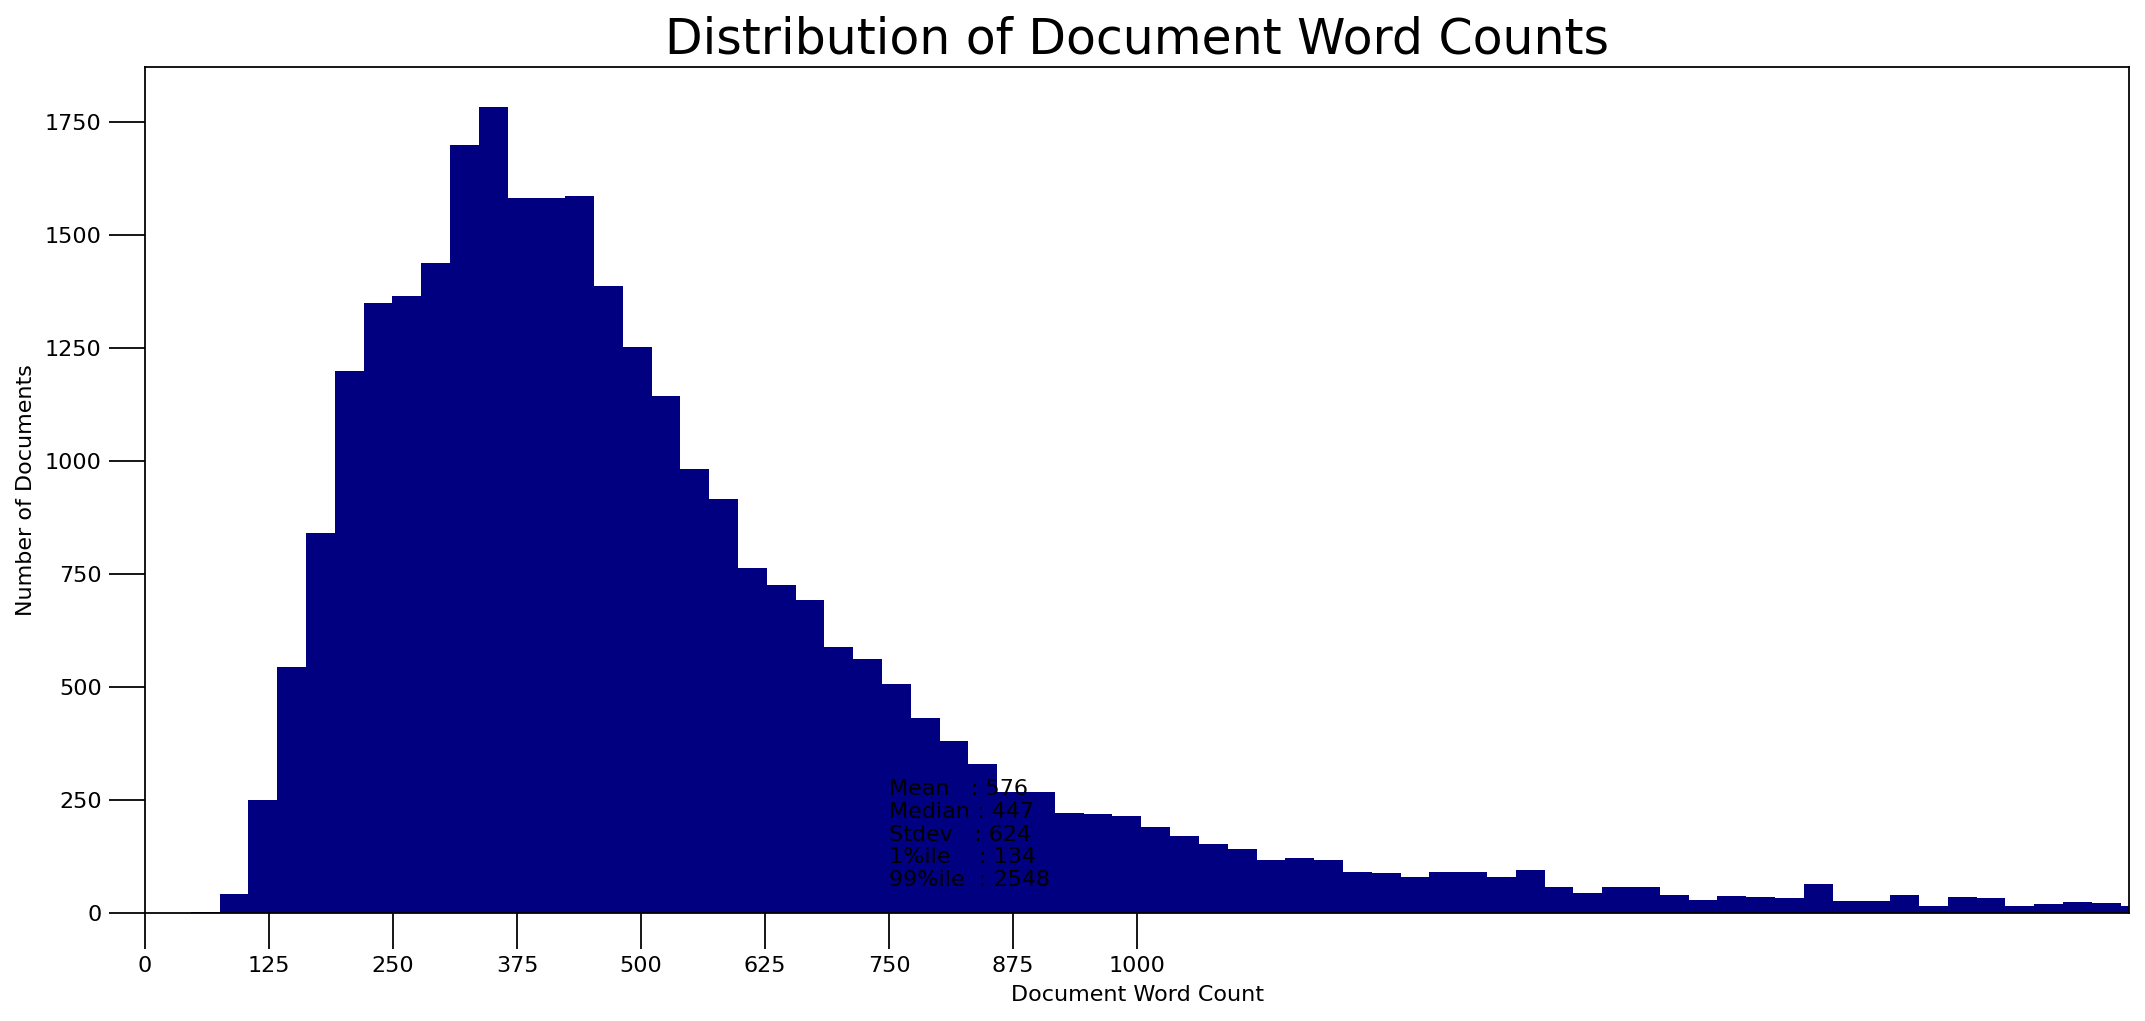

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
# Plot
plt.figure(figsize=(16, 7), dpi=160)
plt.hist(doc_lens, bins=1000, color='navy')
plt.text(750, 260, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 210, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 160, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 110, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.gca().set(xlim=(0, 2000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
print("show graph1")
plt.show()

График 2 - Распределение количества слов в документе по доминирующей теме

show graph2


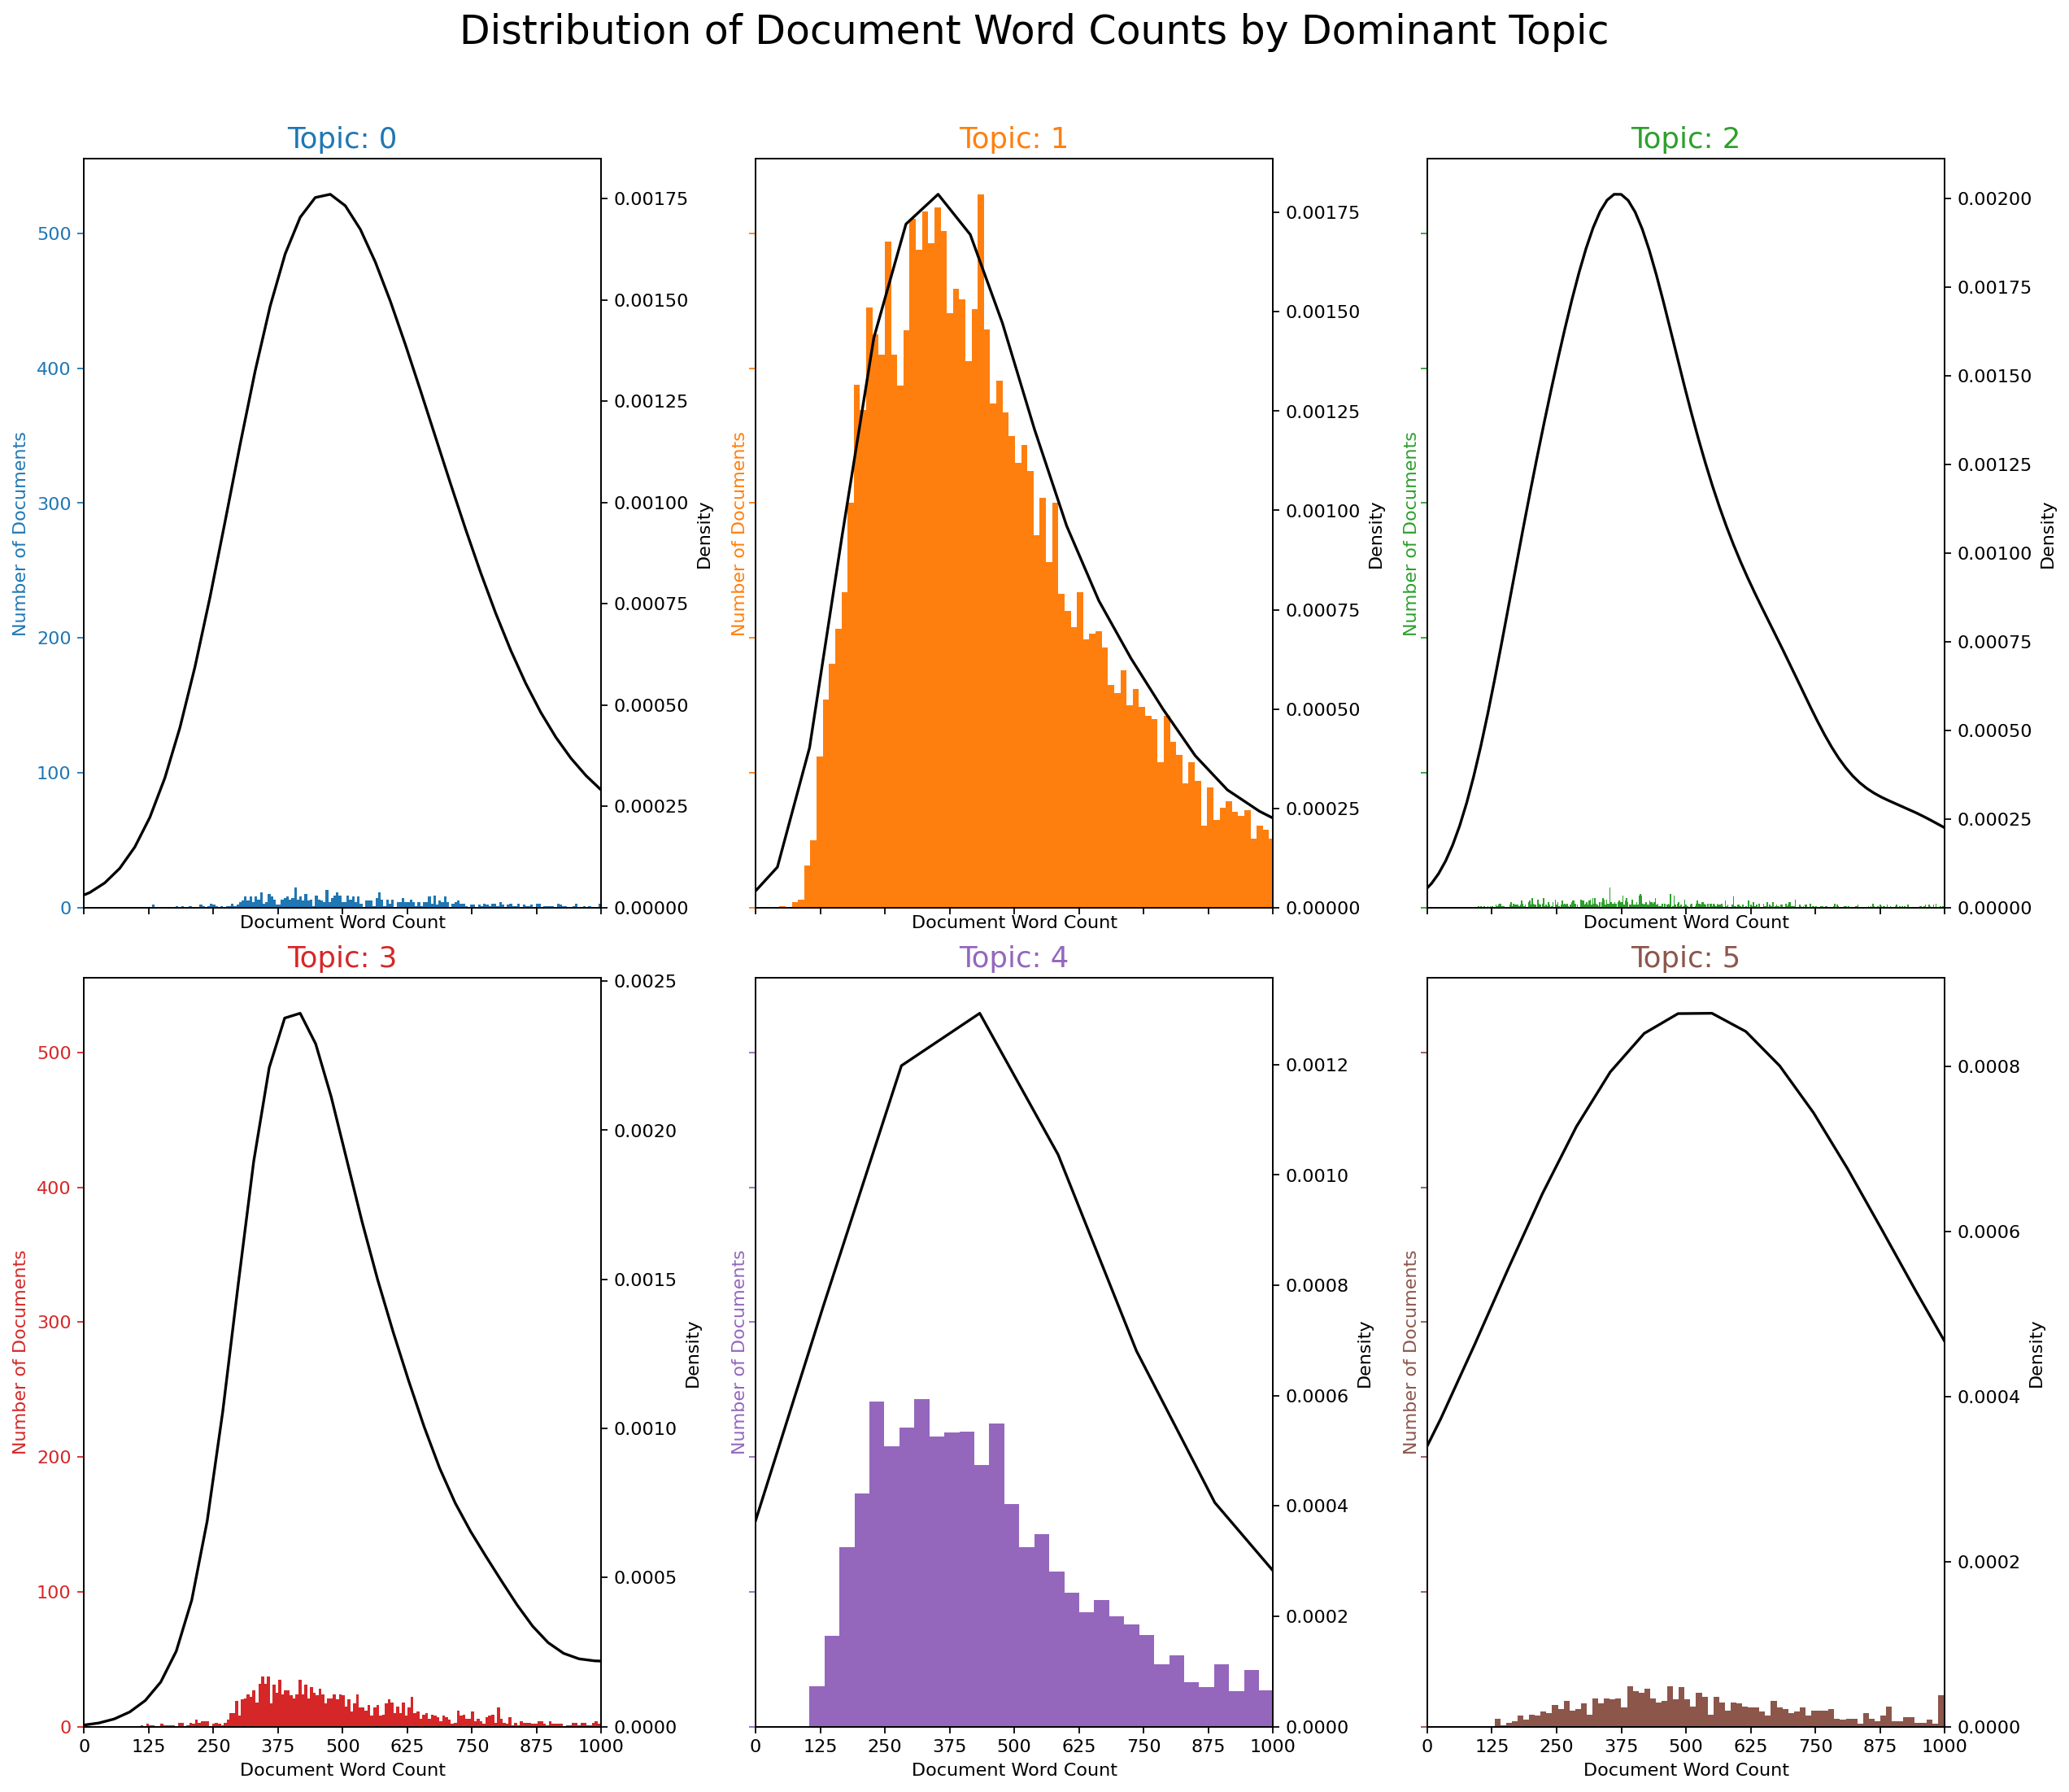

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2, 3, figsize=(16, 14), dpi=160, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: ' + str(i), fontdict=dict(size=16, color=cols[i]))
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0, 1000, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
print("show graph2")
plt.show()

График 3 - Количество слов и важность ключевых слов темы

C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\4032197816.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\4032197816.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\4032197816.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\4032197816.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
C:\Users\maksi\AppData\Local\Temp\ipyker

show graph3


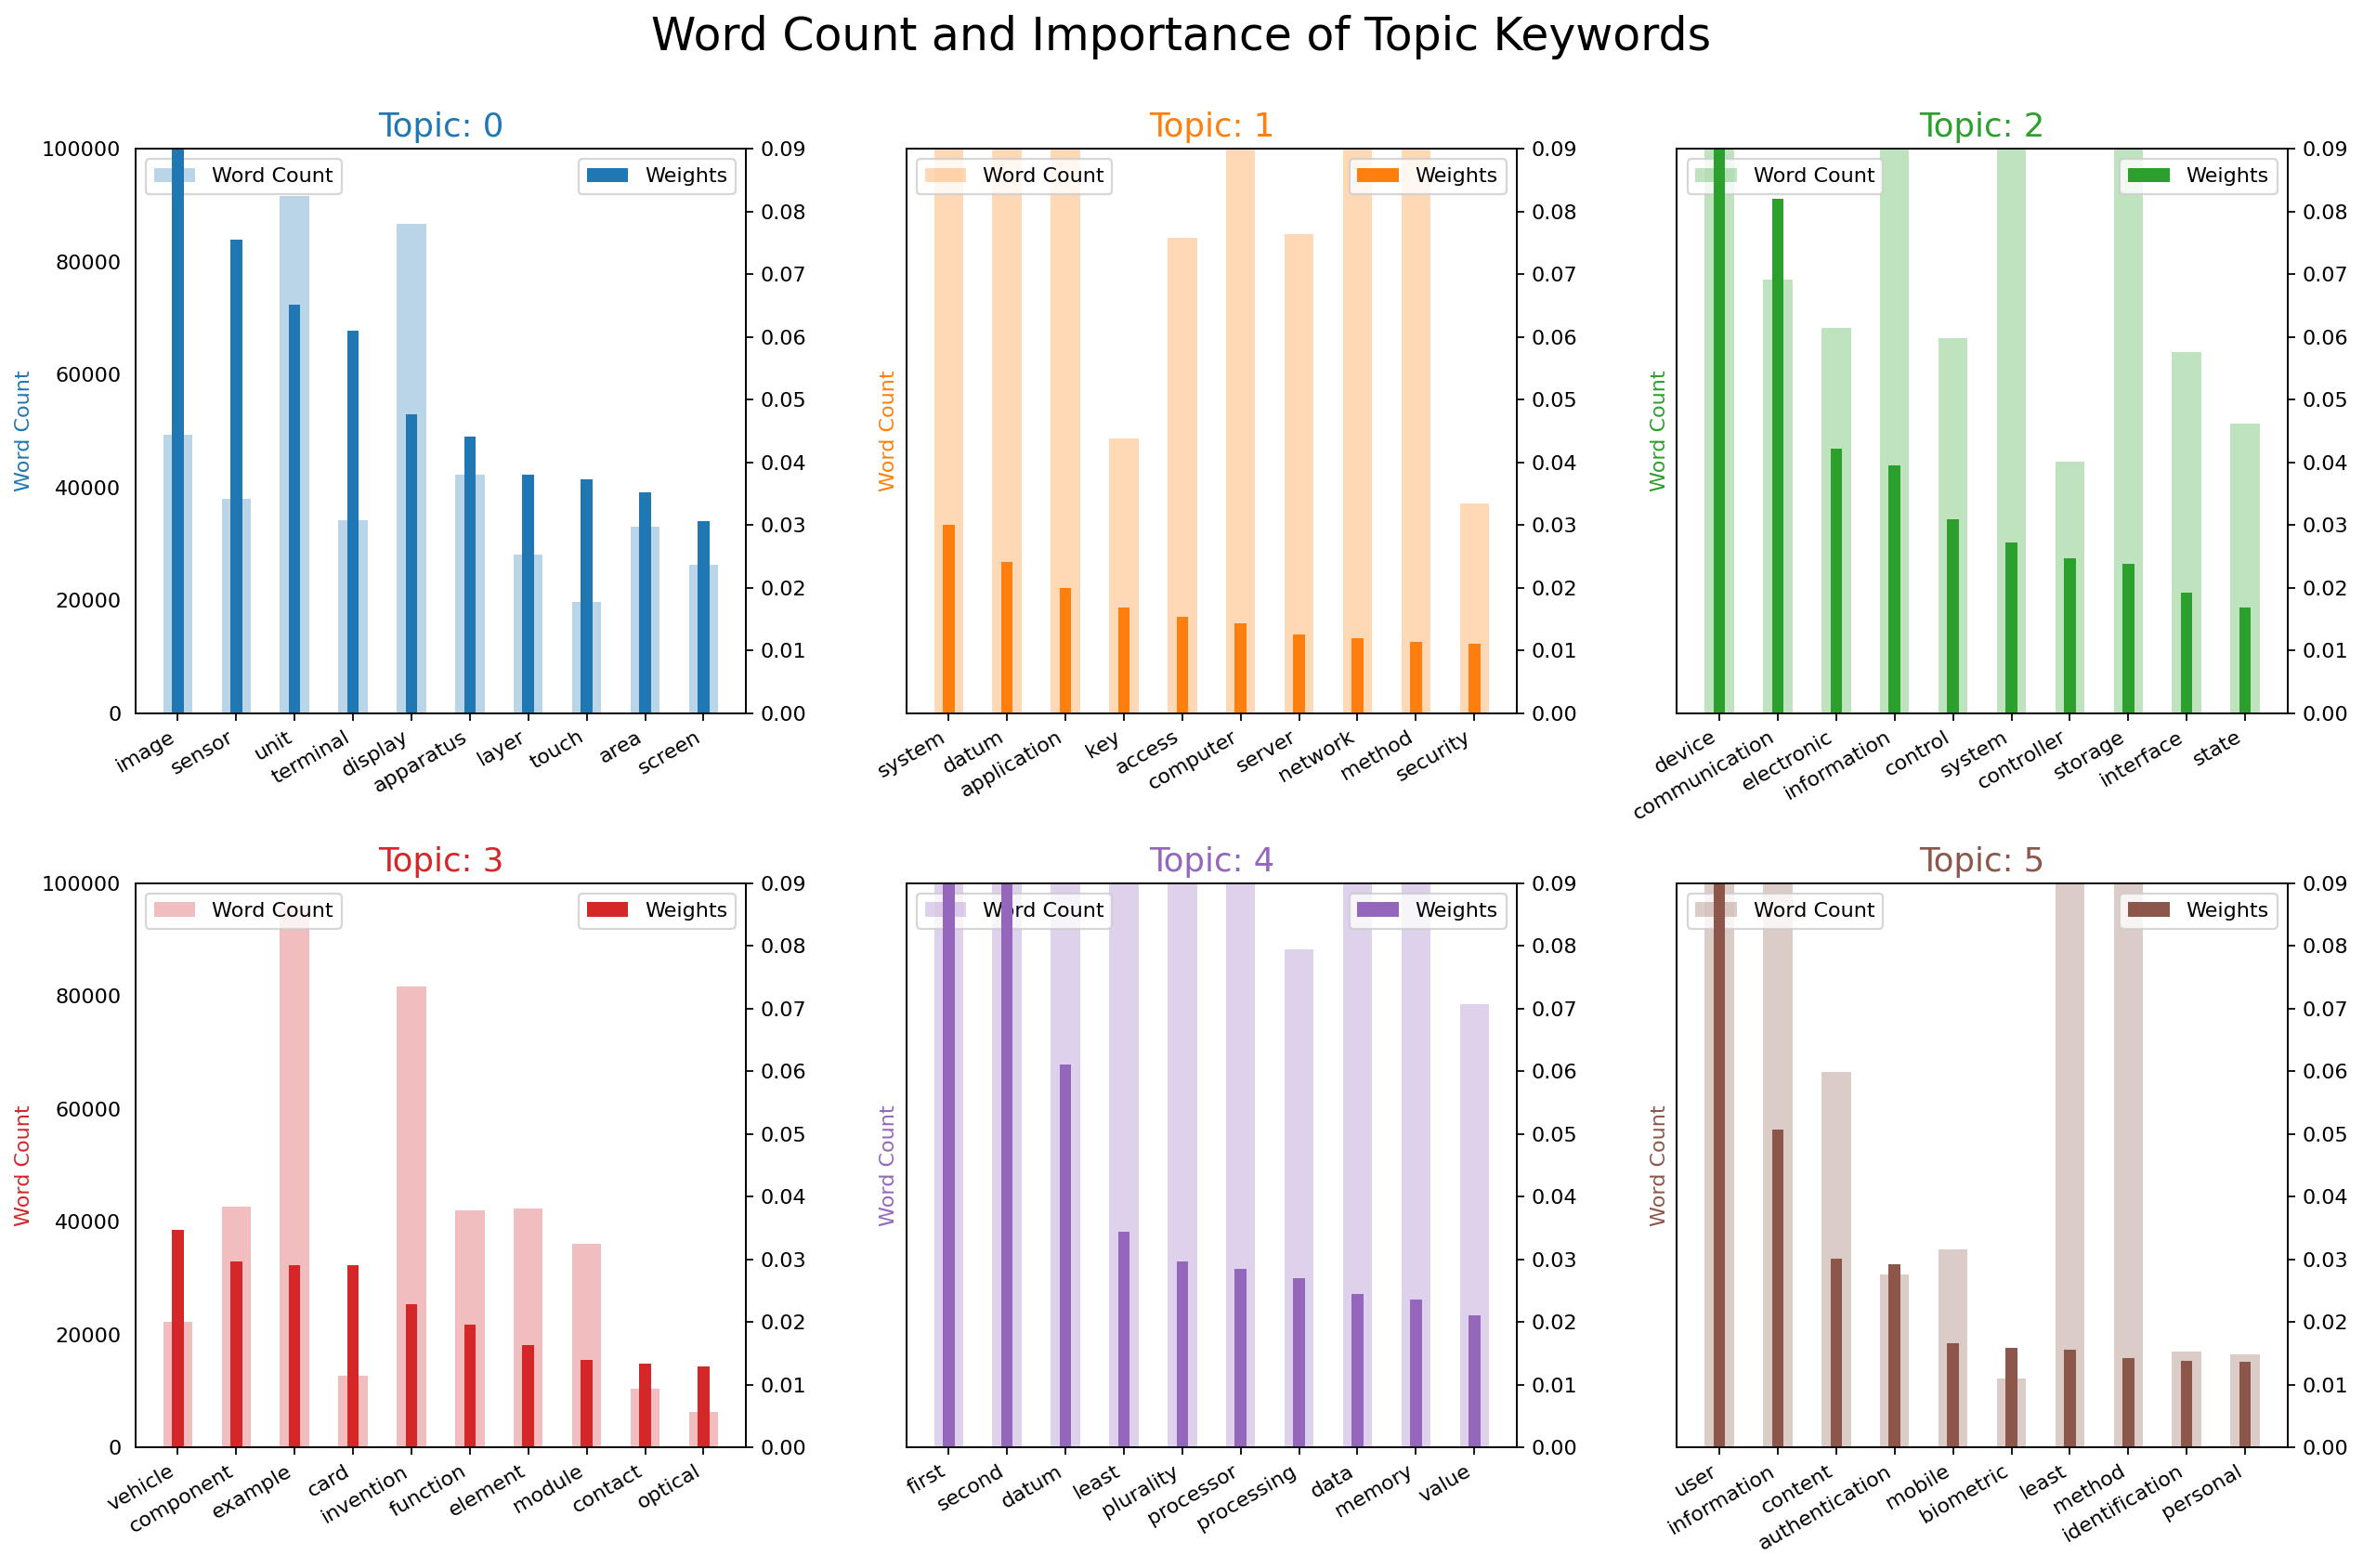

In [23]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3,
           label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id == i, :], color=cols[i], width=0.2,
                label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.09);
    ax.set_ylim(0, 100000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left');
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
print("show graph3")
plt.show()

График 4 - Раскраска темы предложения для документов

Подготовка 3 топ слов по срезу топика

In [25]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return (dominant_topics, topic_percentages)
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                   for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0, inplace=True)

График 5 - Какие темы чаще всего обсуждаются в документах

show graph5


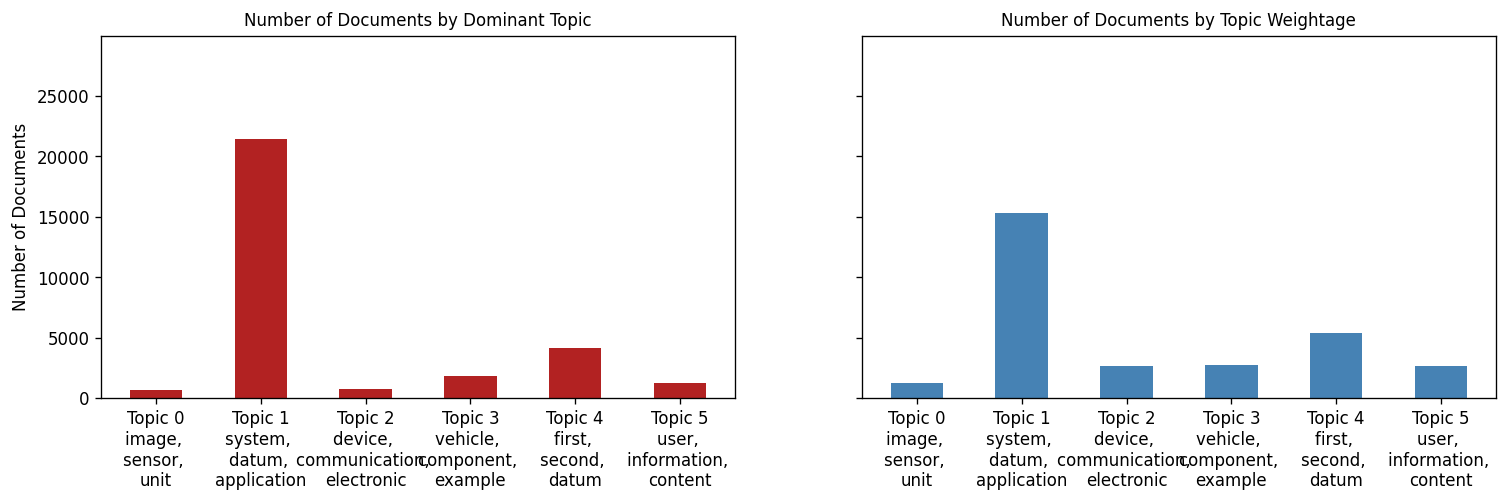

In [34]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(
    lambda x, pos: 'Topic ' + str(x) + '\n' + df_top3words.loc[df_top3words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, rough_df.count())
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
print("show graph5")
plt.show()

График 6

In [35]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27471 samples in 0.107s...
[t-SNE] Computed neighbors for 27471 samples in 2.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27471
[t-SNE] Computed conditional probabilities for sample 2000 / 27471
[t-SNE] Computed conditional probabilities for sample 3000 / 27471
[t-SNE] Computed conditional probabilities for sample 4000 / 27471
[t-SNE] Computed conditional probabilities for sample 5000 / 27471
[t-SNE] Computed conditional probabilities for sample 6000 / 27471
[t-SNE] Computed conditional probabilities for sample 7000 / 27471
[t-SNE] Computed conditional probabilities for sample 8000 / 27471
[t-SNE] Computed conditional probabilities for sample 9000 / 27471
[t-SNE] Computed conditional probabilities for sample 10000 / 27471
[t-SNE] Computed conditional probabilities for sample 11000 / 27471
[t-SNE] Computed conditional probabilities for sample 12000 / 27471
[t-SNE] Computed conditional probabilities for sam

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.606895
[t-SNE] KL divergence after 1000 iterations: 1.615273


Loading BokehJS ...

График 7

In [36]:
!pip install pyLDAvis;
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
print("show graph7")
vis

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


show graph7


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.108999 -0.090519       1        1  49.274581
4     -0.200305 -0.207654       2        1  18.806103
5     -0.189546  0.022006       3        1  10.699846
3      0.186998 -0.036214       4        1   8.674773
2     -0.051135  0.371648       5        1   8.247886
0      0.362988 -0.059267       6        1   4.296812, topic_info=           Term           Freq          Total Category  logprob  loglift
22       device  571976.000000  571976.000000  Default  30.0000  30.0000
38        first  483678.000000  483678.000000  Default  29.0000  29.0000
97         user  235463.000000  235463.000000  Default  28.0000  28.0000
80       second  342089.000000  342089.000000  Default  27.0000  27.0000
126       datum  403860.000000  403860.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
52    invention    8506.990739   84323.990713   Topic6  -4.4694   0.8535
1728    optical    5174.676901   24604.528151   Topic6  -4.9665   1.5881
56       method    7892.106789  170411.507783   Topic6  -4.5444   0.0749
159    location    5097.467105   35585.508140   Topic6  -4.9815   1.2041
204        step    4726.900829   26001.920586   Topic6  -5.0570   1.4424

[384 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
368        2  0.037508        able
368        3  0.201356        able
368        4  0.761097        able
297        1  0.999997      access
216        1  0.240423  accordance
...      ...       ...         ...
15398      1  0.004205        wipe
15398      5  0.995116        wipe
806        1  0.350008    wireless
806        3  0.649982    wireless
5998       5  0.998545        wlan

[575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 4, 3, 1])

In [37]:
def myfunc(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(i), int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['i', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)


df_topic_sents_keywords2 = myfunc(ldamodel=lda_model, corpus=corpus, texts=data_ready)

sparkDFGENSIM = spark.createDataFrame(df_topic_sents_keywords2)
sparkDFGENSIM.show(10)


window = pyspark.sql.Window.partitionBy("maingroup", "Dominant_Topic")
sparkdfgensimres = sparkDFGENSIM.withColumn("maingroup", when(sparkDFGENSIM.i <= 5000, 1).when(sparkDFGENSIM.i <= 10000, 11).when(sparkDFGENSIM.i <= 15000, 12).when(sparkDFGENSIM.i <= 20000, 13).when(sparkDFGENSIM.i <= 25000, 15).otherwise(21)) \
    .select("Dominant_Topic", "maingroup").withColumn("countEachPatentToTopic",
                                                      count("Dominant_Topic").over(window)).distinct().orderBy("maingroup")

C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\1460029436.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
C:\Users\maksi\AppData\Local\Temp\ipykernel_11972\1460029436.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


+---+--------------+-------------------+--------------------+--------------------+
|  i|Dominant_Topic|  Perc_Contribution|      Topic_Keywords|                   0|
+---+--------------+-------------------+--------------------+--------------------+
|  0|             1| 0.5527999997138977|system, datum, ap...|[field, embodimen...|
|  1|             3|0.43140000104904175|vehicle, componen...|[embodiment, pres...|
|  2|             3|  0.335099995136261|vehicle, componen...|[embodiment, pres...|
|  3|             0|   0.32710000872612|image, sensor, un...|[embodiment, pres...|
|  4|             3|0.40689998865127563|vehicle, componen...|[embodiment, pres...|
|  5|             5| 0.2637999951839447|user, information...|[embodiment, pres...|
|  6|             3|0.48730000853538513|vehicle, componen...|[present, inventi...|
|  7|             3| 0.6568999886512756|vehicle, componen...|[present, inventi...|
|  8|             5|  0.444599986076355|user, information...|[present, inventi...|
|  9

In [55]:
sparkdfgensimres.orderBy("Dominant_Topic","maingroup").show(100,False)

+--------------+---------+----------------------+
|Dominant_Topic|maingroup|countEachPatentToTopic|
+--------------+---------+----------------------+
|0             |1        |508                   |
|0             |11       |12                    |
|0             |12       |2                     |
|0             |13       |27                    |
|0             |15       |15                    |
|0             |21       |52                    |
|1             |1        |1422                  |
|1             |11       |4220                  |
|1             |12       |3945                  |
|1             |13       |3290                  |
|1             |15       |4351                  |
|1             |21       |4170                  |
|2             |1        |314                   |
|2             |11       |51                    |
|2             |12       |50                    |
|2             |13       |250                   |
|2             |15       |54                    |


# *PYSPARK LDA и графики*

In [39]:
num_topics=6
max_iterations=100
lda = LDA(k=num_topics, maxIter=max_iterations)
ldaModel = lda.fit(count_vectorized_df)

In [40]:
# Print topics and top-weighted terms
topics = ldaModel.describeTopics(maxTermsPerTopic=10)
vocabArray = count_vectorized_model.vocabulary
numTopics=6

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyspark\sql\context.py:118: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----------------------------------------------------------------------------------------------------+
|words                                                                                                |
+-----------------------------------------------------------------------------------------------------+
|[power, control, unit, circuit, processor, signal, output, interface, processing, module]            |
|[display, portion, image, sensor, surface, screen, user, area, input, layer]                         |
|[information, user, content, message, communication, access, medium, authentication, time, invention]|
|[associated, file, processor, plurality, information, user, security, value, set, response]          |
|[network, service, server, resource, node, machine, process, client, information, management]        |
|[memory, storage, block, operation, address, cache, plurality, host, access, controller]             |
+---------------------------------------------------------------

In [41]:
ldaModel.isDistributed()

False

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [43]:
from pyspark.sql.functions import when
dfspark = spark.createDataFrame(df)
dfspark2 = dfspark.withColumn("type", when(dfspark.Document_Id <= 5000, 1).when(dfspark.Document_Id <= 10000, 11).when(dfspark.Document_Id <= 15000, 12).when(dfspark.Document_Id <= 20000, 13).when(dfspark.Document_Id <= 25000, 15).otherwise(21))
from pyspark.sql import Window
from pyspark.sql.functions import count
window = Window.partitionBy("type", "Dominant_Topic").orderBy("Dominant_Topic")
dfspark3 = dfspark2.select("type", "Dominant_Topic").withColumn("countEachPatentToTopic", count("Dominant_Topic").over(window)).distinct().orderBy("type")

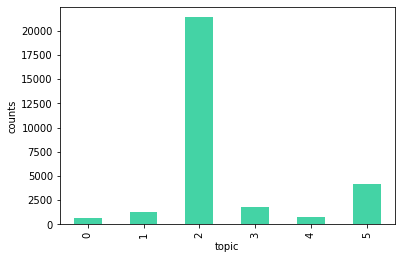

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyspark\sql\context.py:118: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


topic: 0
*************************
power
control
unit
circuit
processor
signal
output
interface
processing
module
*************************
topic: 1
*************************
display
portion
image
sensor
surface
screen
user
area
input
layer
*************************
topic: 2
*************************
information
user
content
message
communication
access
medium
authentication
time
invention
*************************
topic: 3
*************************
associated
file
processor
plurality
information
user
security
value
set
response
*************************
topic: 4
*************************
network
service
server
resource
node
machine
process
client
information
management
*************************
topic: 5
*************************
memory
storage
block
operation
address
cache
plurality
host
access
controller
*************************


In [44]:
dfspark4 = dfspark3.select("Dominant_Topic", "countEachPatentToTopic").groupBy("Dominant_Topic").sum()
pdf = dfspark4.toPandas()
pdf.plot(color='#44D3A5', legend=False,
         kind='bar', use_index=True, y='sum(countEachPatentToTopic)', grid=False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

vocab = count_vectorized_model.vocabulary
topics = ldaModel.describeTopics()
topics_rdd = topics.rdd
topics_words = topics_rdd \
    .map(lambda row: row['termIndices']) \
    .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
    .collect()
for idx, topic in enumerate(topics_words):
    print("topic: {}".format(idx))
    print("*" * 25)
    for word in topic:
        print(word)
    print("*" * 25)


In [45]:
dfspark3.show(10,False)

+----+--------------+----------------------+
|type|Dominant_Topic|countEachPatentToTopic|
+----+--------------+----------------------+
|1   |1             |1422                  |
|1   |5             |351                   |
|1   |0             |508                   |
|1   |4             |848                   |
|1   |3             |1558                  |
|1   |2             |314                   |
|11  |1             |4220                  |
|11  |3             |26                    |
|11  |0             |12                    |
|11  |5             |35                    |
+----+--------------+----------------------+
only showing top 10 rows



In [46]:
def format_data_to_pyldavis(df_filtered, count_vectorizer, transformed, lda_model):
    xxx = df_filtered.select((explode(df_filtered.lemmatized_good_words)).alias("words")).groupby("words").count()
    word_counts = {r['words']:r['count'] for r in xxx.collect()}
    word_counts = [word_counts[w] for w in count_vectorizer.vocabulary]


    data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
            'doc_topic_dists': np.array([x.toArray() for x in transformed.select(["topicDistribution"]).toPandas()['topicDistribution']]),
            'doc_lengths': [r[0] for r in df_filtered.select(size(df_filtered.lemmatized_good_words)).collect()],
            'vocab': count_vectorizer.vocabulary,
            'term_frequency': word_counts}

    return data

def filter_bad_docs(data):
    bad = 0
    doc_topic_dists_filtrado = []
    doc_lengths_filtrado = []

    for x,y in zip(data['doc_topic_dists'], data['doc_lengths']):
        if np.sum(x)==0:
            bad+=1
        elif np.sum(x) != 1:
            bad+=1
        elif np.isnan(x).any():
            bad+=1
        else:
            doc_topic_dists_filtrado.append(x)
            doc_lengths_filtrado.append(y)

    data['doc_topic_dists'] = doc_topic_dists_filtrado
    data['doc_lengths'] = doc_lengths_filtrado


In [47]:
!pip install pyLDAvis

In [48]:
import pyLDAvis
from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer, CountVectorizer, IDF
from pyspark.sql.functions import udf, col, size, explode, regexp_replace, trim, lower, lit
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, LongType
from pyspark.ml.clustering import LDA
pyLDAvis.enable_notebook()
data = format_data_to_pyldavis(count_vectorized_df, count_vectorized_model, ldaModel.transform(count_vectorized_df), ldaModel)
filter_bad_docs(data) # this is, because for some reason some docs apears with 0 value in all the vectors, or the norm is not 1, so I filter those docs.
py_lda_prepared_data = pyLDAvis.prepare(**data)
pyLDAvis.display(py_lda_prepared_data)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# *SKLEARN LDA и графики*

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

docs_raw = pd.read_parquet('C:\\Users\\maksi\\Documents\\VKR_FOLDER\\vkr\\VKR_Module_3\\~\\dataset_1_11_12_13_15_21_5k')['text'].tolist()
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 0.02)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [50]:
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=6, random_state=0)

       Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  dominant_topic doc_id  \
0        0.02    0.39    0.02    0.51    0.03    0.02               3      0   
1        0.03    0.02    0.03    0.03    0.87    0.02               4      1   
2        0.02    0.02    0.02    0.02    0.89    0.02               4      2   
3        0.42    0.02    0.02    0.02    0.49    0.02               4      3   
4        0.02    0.02    0.02    0.02    0.90    0.02               4      4   
...       ...     ...     ...     ...     ...     ...             ...    ...   
29989    0.02    0.02    0.02    0.88    0.02    0.02               3  29989   
29990    0.02    0.02    0.02    0.88    0.02    0.02               3  29990   
29991    0.02    0.02    0.90    0.02    0.02    0.02               2  29991   
29992    0.02    0.02    0.02    0.89    0.02    0.02               3  29992   
29993    0.02    0.02    0.88    0.02    0.02    0.02               2  29993   

       doc_type  
0             0  
1  

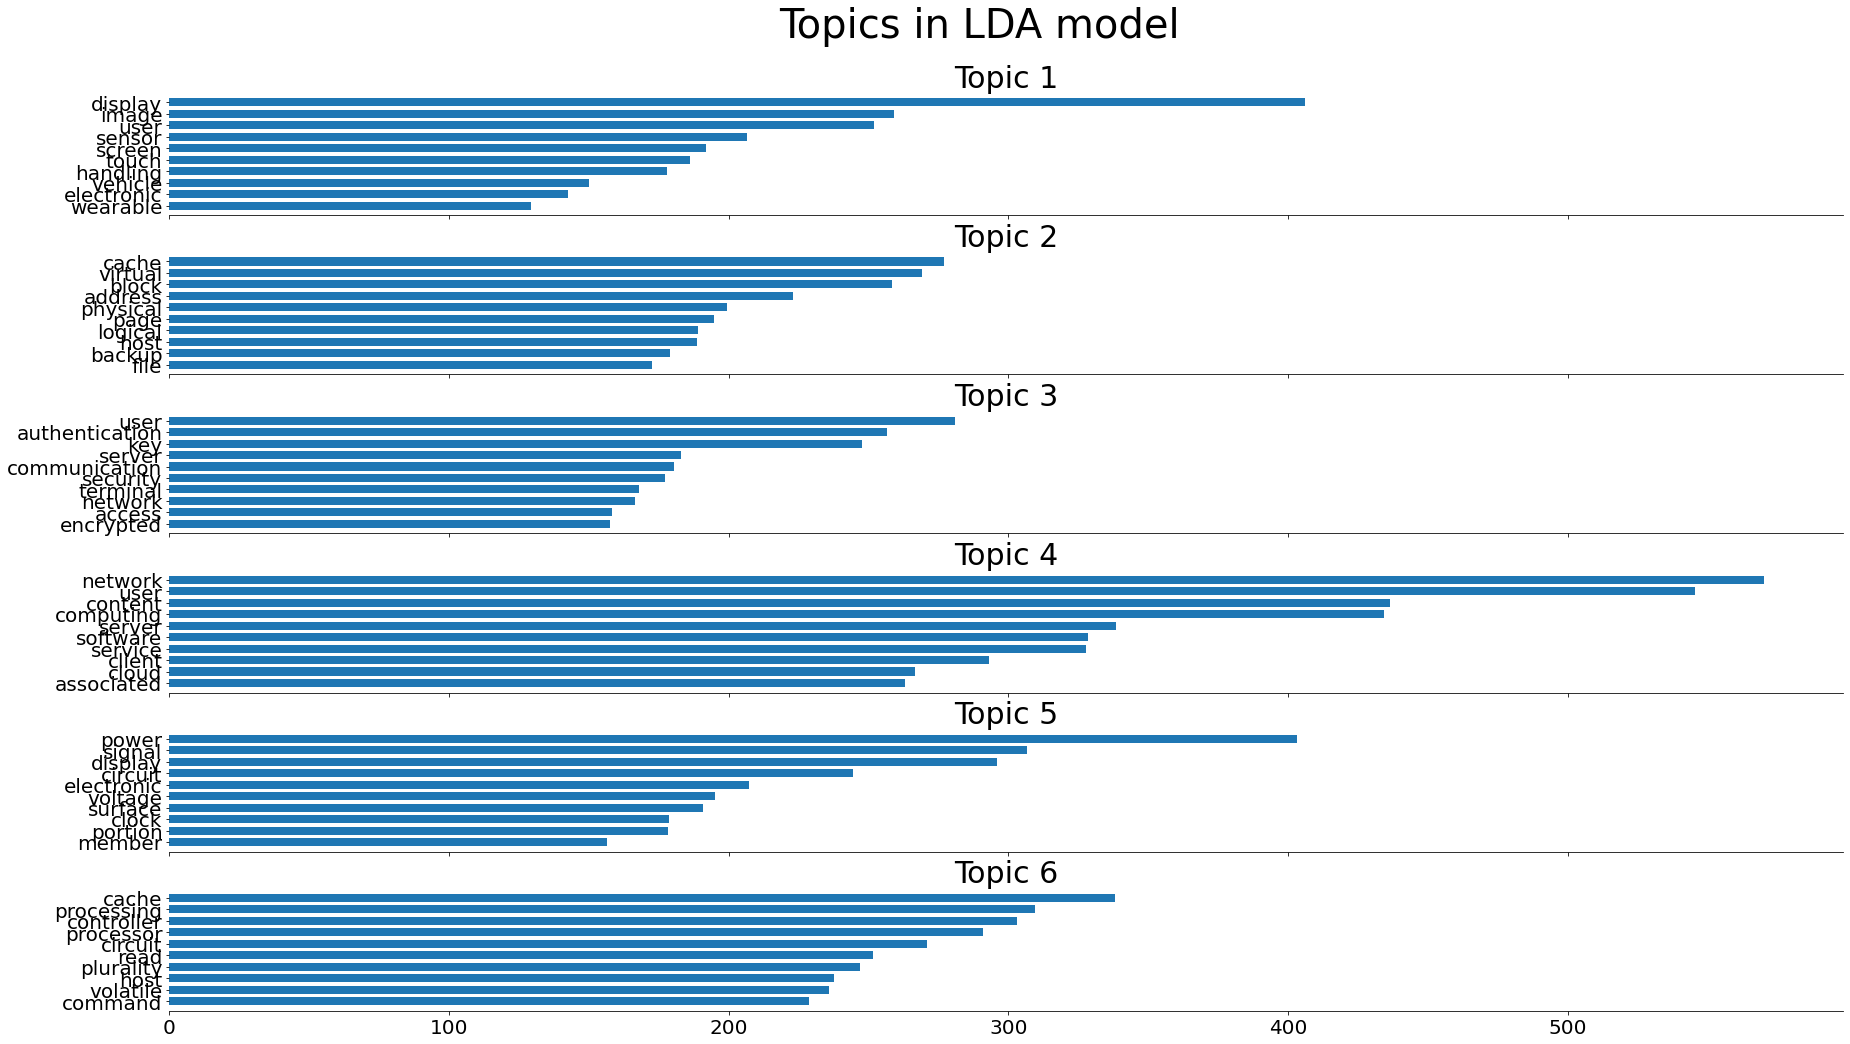

In [51]:
from math import floor

lda_output = lda_tfidf.transform(dtm_tfidf)

# Create Document — Topic Matrix
topicnames = ["Topic" + str(i) for i in range(lda_tfidf.n_components)]
# index names
docnames = [str(i) for i in range(len(docs_raw))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
df_document_topic["doc_id"] = df_document_topic.index
df_document_topic["doc_type"] = [floor(i / (len(docs_raw) / lda_tfidf.n_components)) for i in range(len(docs_raw))]

print(df_document_topic)

testdf = df_document_topic[['dominant_topic','doc_type']]\
    .groupby(['dominant_topic','doc_type'])\
    .size().reset_index(name="counts")

print(testdf)

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 1, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda_tfidf, tf_feature_names, 10, "Topics in LDA model")

In [52]:
!pip install pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\maksi\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.068648 -0.056214       1        1  31.909581
5      0.027917  0.092763       2        1  20.323161
1      0.118163  0.058071       3        1  13.700791
2      0.036245 -0.090902       4        1  12.130093
4     -0.150270  0.053912       5        1  12.114737
0     -0.100702 -0.057630       6        1   9.821637, topic_info=           Term         Freq        Total Category  logprob  loglift
550     display   799.000000   799.000000  Default  30.0000  30.0000
1927       user  1152.000000  1152.000000  Default  29.0000  29.0000
1350      power   696.000000   696.000000  Default  28.0000  28.0000
208       cache   644.000000   644.000000  Default  27.0000  27.0000
862       image   447.000000   447.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1911       unit    93.134619   652.760320   Topic6  -5.3328   0.3734
1692     signal    87.114382   575.447398   Topic6  -5.3996   0.4327
1194     object    79.174473   372.159556   Topic6  -5.4952   0.7729
1132       mode    77.684356   348.939193   Topic6  -5.5142   0.8183
942   interface    81.995480   539.156573   Topic6  -5.4601   0.4372

[369 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         1  0.264182  access
3         2  0.318486  access
3         3  0.159977  access
3         4  0.237764  access
3         5  0.010274  access
...     ...       ...     ...
1999      1  0.025722   write
1999      2  0.527303   write
1999      3  0.432132   write
1999      4  0.012861   write
1999      5  0.005144   write

[1488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 3, 5, 1])